Preparations

In [0]:
#!rm -r data

In [0]:
#!rm -r /content/data/task_1/training_classes/

In [0]:
import os
import io
import pickle
import requests
import zipfile
from pathlib import Path
import numpy as np

from PIL import Image
from scipy import ndimage
from imageio import imread, imsave
from skimage import img_as_float, color, exposure
from skimage.transform import resize
from skimage.feature import peak_local_max, hog
from skimage.segmentation import clear_border
from skimage.morphology import label
from skimage.measure import regionprops

from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

In [0]:
# read file with the image and convert it to binary image -
# ndarray with 1.0 and 0.0
def get_binary_image(path_to_image):
  image = Image.open(path_to_image).convert('L')
  image = np.asarray(image, )

  #apply threshold in order to make the image binary
  bw = (image < 120).astype(np.float)

  return bw

In [0]:
# Returns the list of bboxes from the image.
# Image should be an np 2D array of 0.0 and 1.0
# bbox is a tuple (minr, minc, maxr, maxc) where first 2 elements
# are coordinates of top left corner of a character and the last 2 elements
# are coordinates of bottom right corner of a character.
def get_bboxes(binary_image):
  print("getting bboxes from image")
  bboxes = []

  # remove artifacts connected to image border
  cleared = binary_image.copy()
  clear_border(cleared)

  # label image regions
  label_image = label(cleared,neighbors=8)
  borders = np.logical_xor(binary_image, cleared)
  label_image[borders] = -1

  for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    # Skip small regions
    if maxr - minr > len(binary_image) / 250:  # better to use height rather than area.
      # increase the height to include umlauts
      height = maxr - minr
      width = maxc - minc
      h_extension = height // 2 # not * 0.5 because it will produce decimals
      enlarged_bbox = (minr - h_extension, minc, maxr, maxc)
      bboxes.append(enlarged_bbox)
  return bboxes


In [0]:
# Sorts the bboxes left->right, top->bottom and returns 2d array of bboxes
def sort_bboxes(bboxes):
  print("sorting bboxes")
  lines = list()
  first_in_line = ''
  counter = 0

  # worst case scenario there can be 1 character per line
  for x in range(len(bboxes)):
      lines.append([])

  for character in bboxes:
      if first_in_line == '':
          first_in_line = character
          lines[counter].append(character)
      elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
          lines[counter].append(character)
      elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
          first_in_line = character
          counter += 1
          lines[counter].append(character)

  for x in range(len(lines)):
    lines[x].sort(key=lambda tup: tup[1])

  return lines

In [0]:
def get_images_from_bboxes(bw, lines):
  print("getting images from bboxes")
  # tl - top left,
  # tr - top right,
  # bl - bottom left,
  # br - bottom right
  final = list()
  tr_prev = 0
  prev_line_br = 0

  for line_index in range(len(lines)):
      for char_index in range(len(lines[line_index])):
          tl_next = lines[line_index][char_index][1]
          bl_next = lines[line_index][char_index][0]
          # if next bbox does not intersect with the previous one
          # and
          if tl_next > tr_prev and bl_next > prev_line_br:
              # Get coordinates of a current char
              tl, tr, bl, br = lines[line_index][char_index]
              # Extract image 
              letter_raw = bw[tl:bl, tr:br]
              # Resize it
              letter_norm = resize(letter_raw, (20, 20))
              # Add to the output
              final.append(letter_norm)
              # Update the previous right line value
              tr_prev = lines[line_index][char_index][3]
          # if it was last char in a row
          if char_index == (len(lines[line_index]) - 1):
              # set prev_line_br to the bottom left pixel of the last char
              prev_line_br = lines[line_index][char_index][2]
      tr_prev = 0
      tl_next = 0
  return final

In [0]:
# Shows character borders on the image
def show_bboxes(path_to_image):
  bw = get_binary_image(path_to_image=path_to_image)

  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(32, 32))
  ax.imshow(bw, cmap='jet')

  bboxes = get_bboxes(bw)
  
  for minr, minc, maxr, maxc in bboxes:
    height = maxr - minr
    width = maxc - minc
    rect = mpatches.Rectangle((minc, minr), width, height,
                                    fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

  plt.show()

In [0]:
# Draws already existing bboxes on the image
def show_bboxes2(bw, lines):
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(32, 32))
  ax.imshow(bw, cmap='jet')

  for line in lines:
    line_length = len(line)
    for minr, minc, maxr, maxc in line:
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=1)
      ax.add_patch(rect)
  plt.show()

Task 1: Recognising printed pages for multiple languages

Russian

Unsuccessful attempt to create a training samples automatically from png images of pages of character samples.

In [0]:
# Get data
import tarfile

r = requests.get('https://github.com/Satilianius/COM2028/raw/master/Classifier/data.tar')
with tarfile.open(fileobj=io.BytesIO(r.content), mode="r") as t:
  t.extractall(path='/content/')

getting bboxes from image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


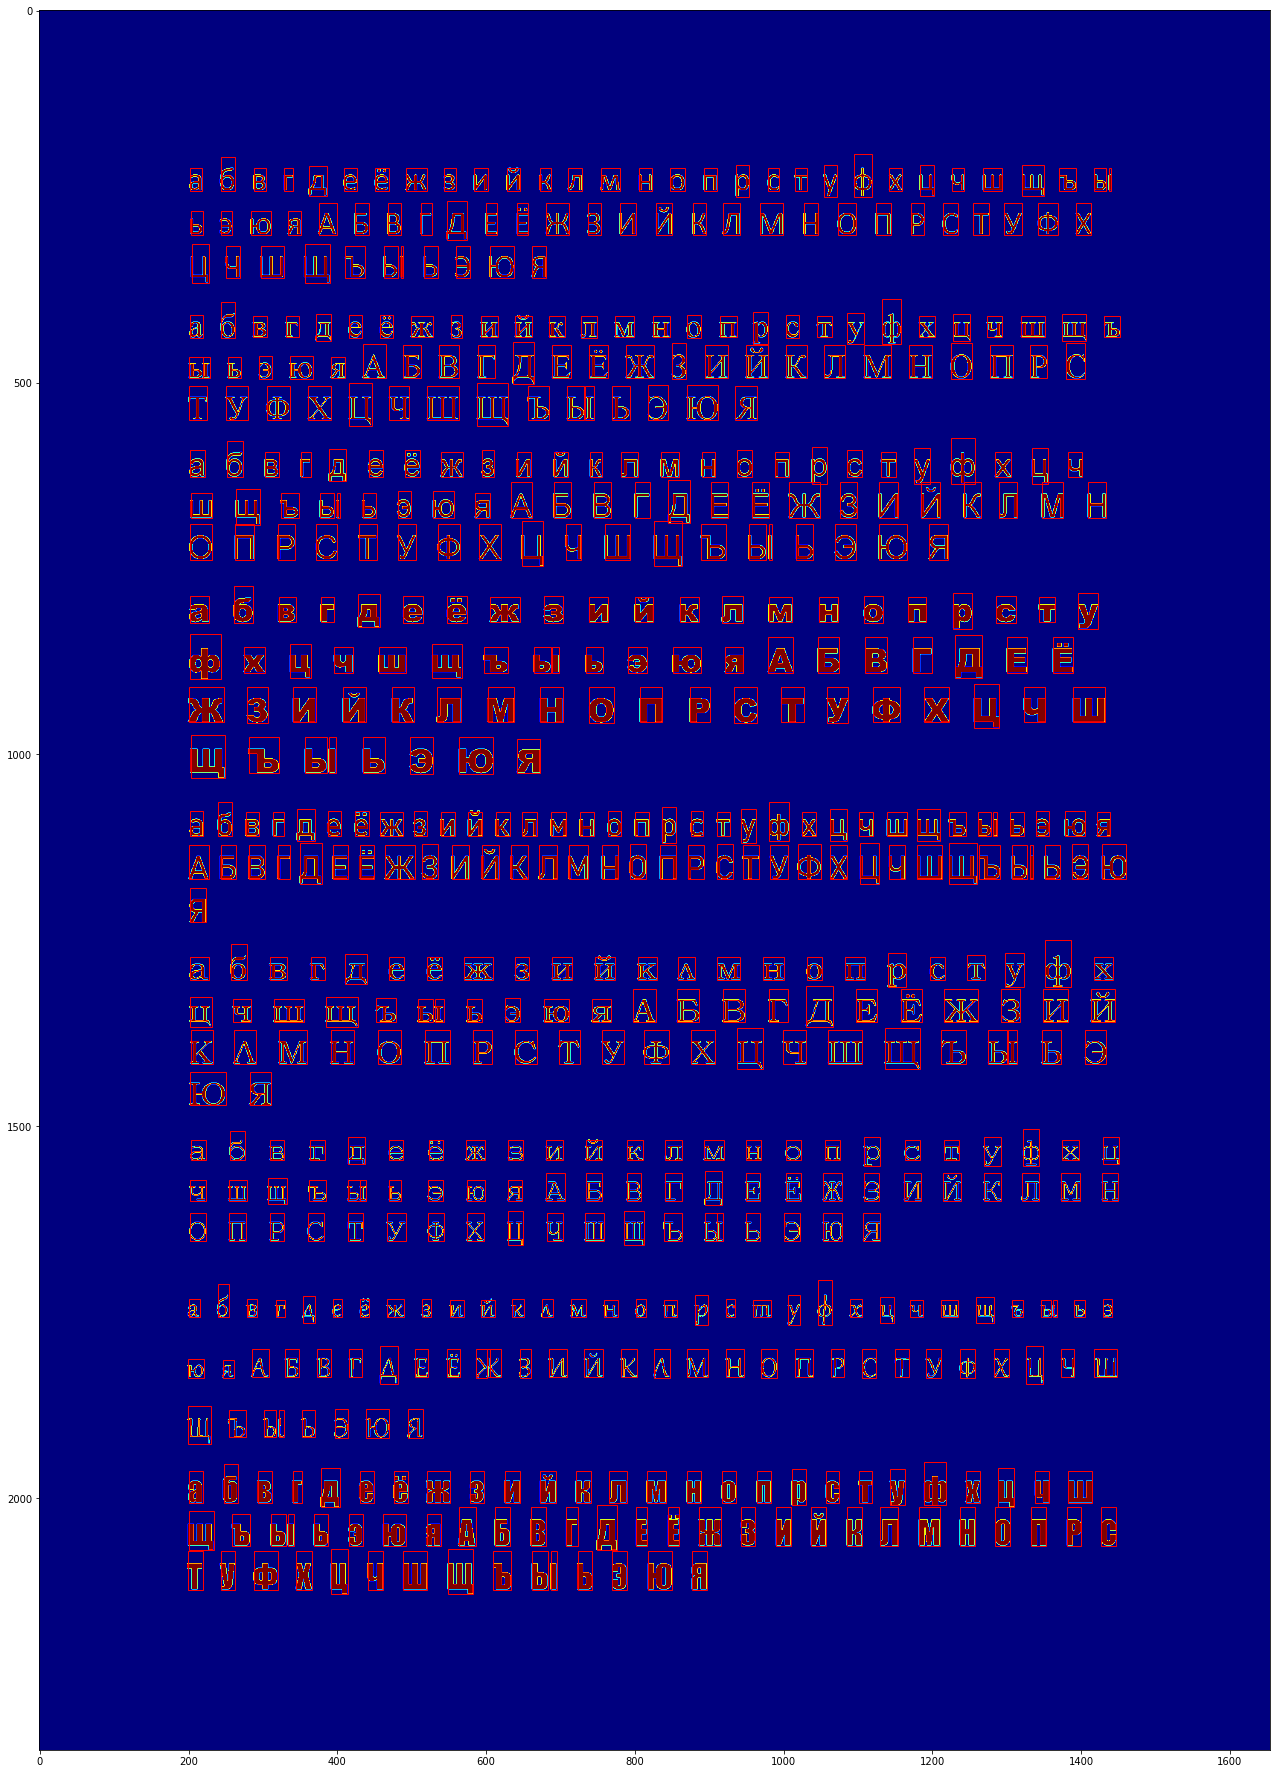

getting bboxes from image


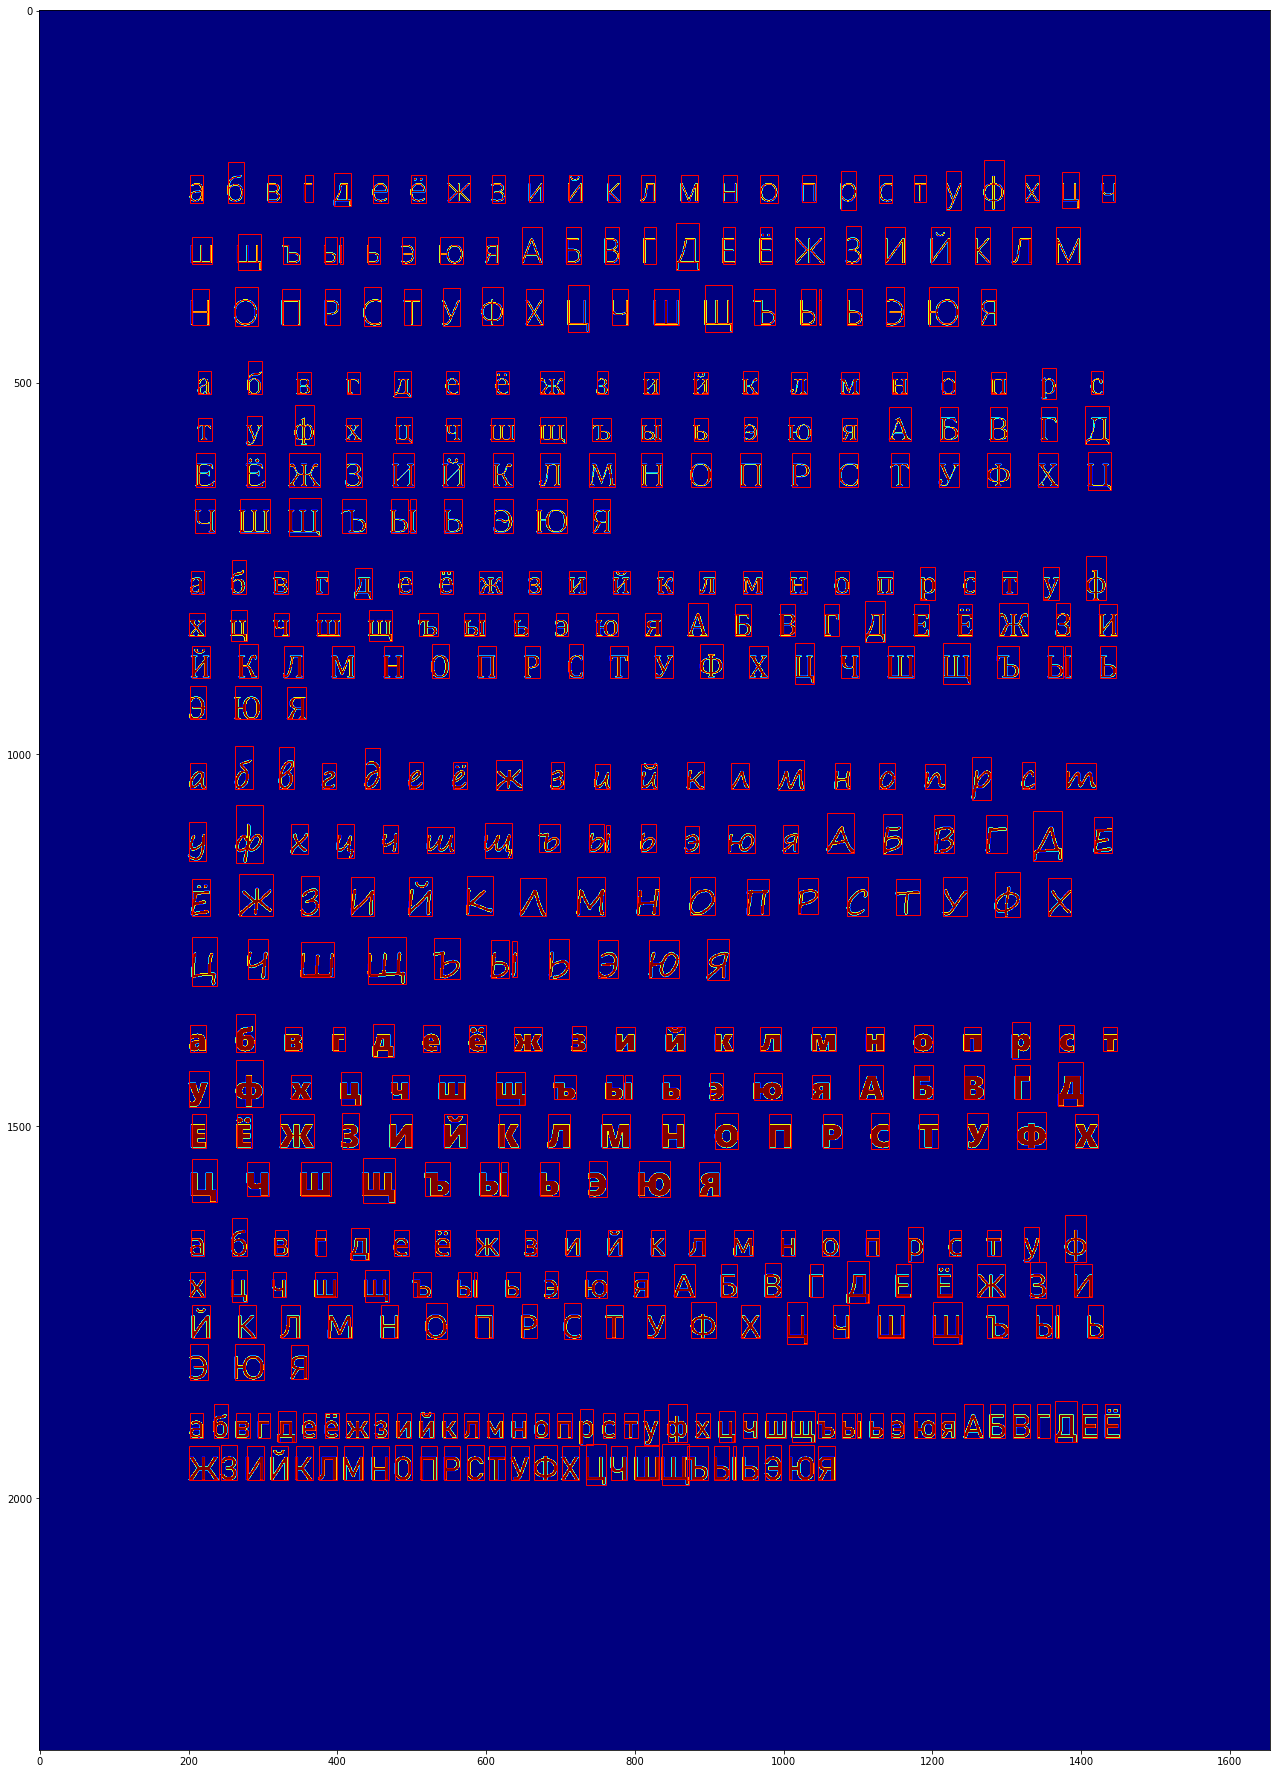

getting bboxes from image


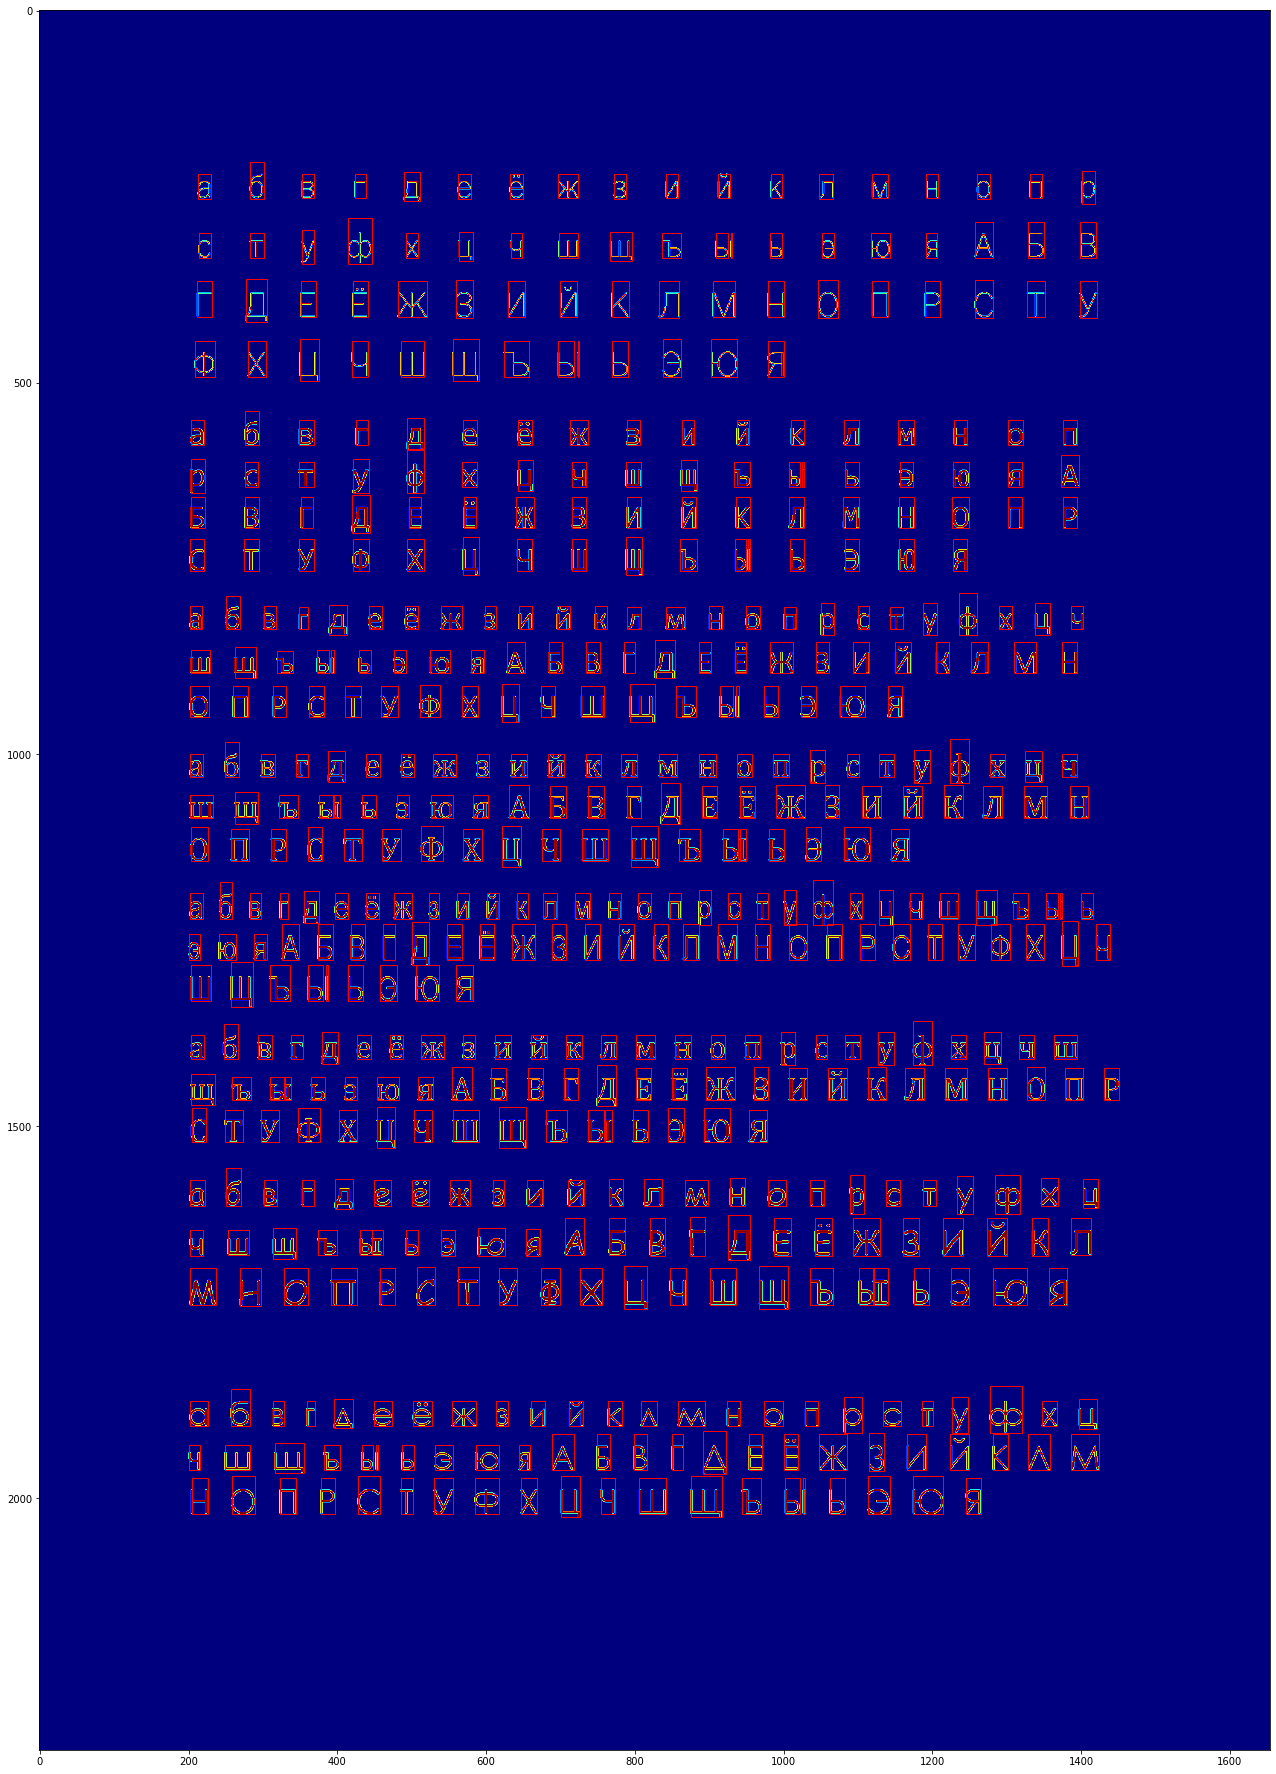

getting bboxes from image


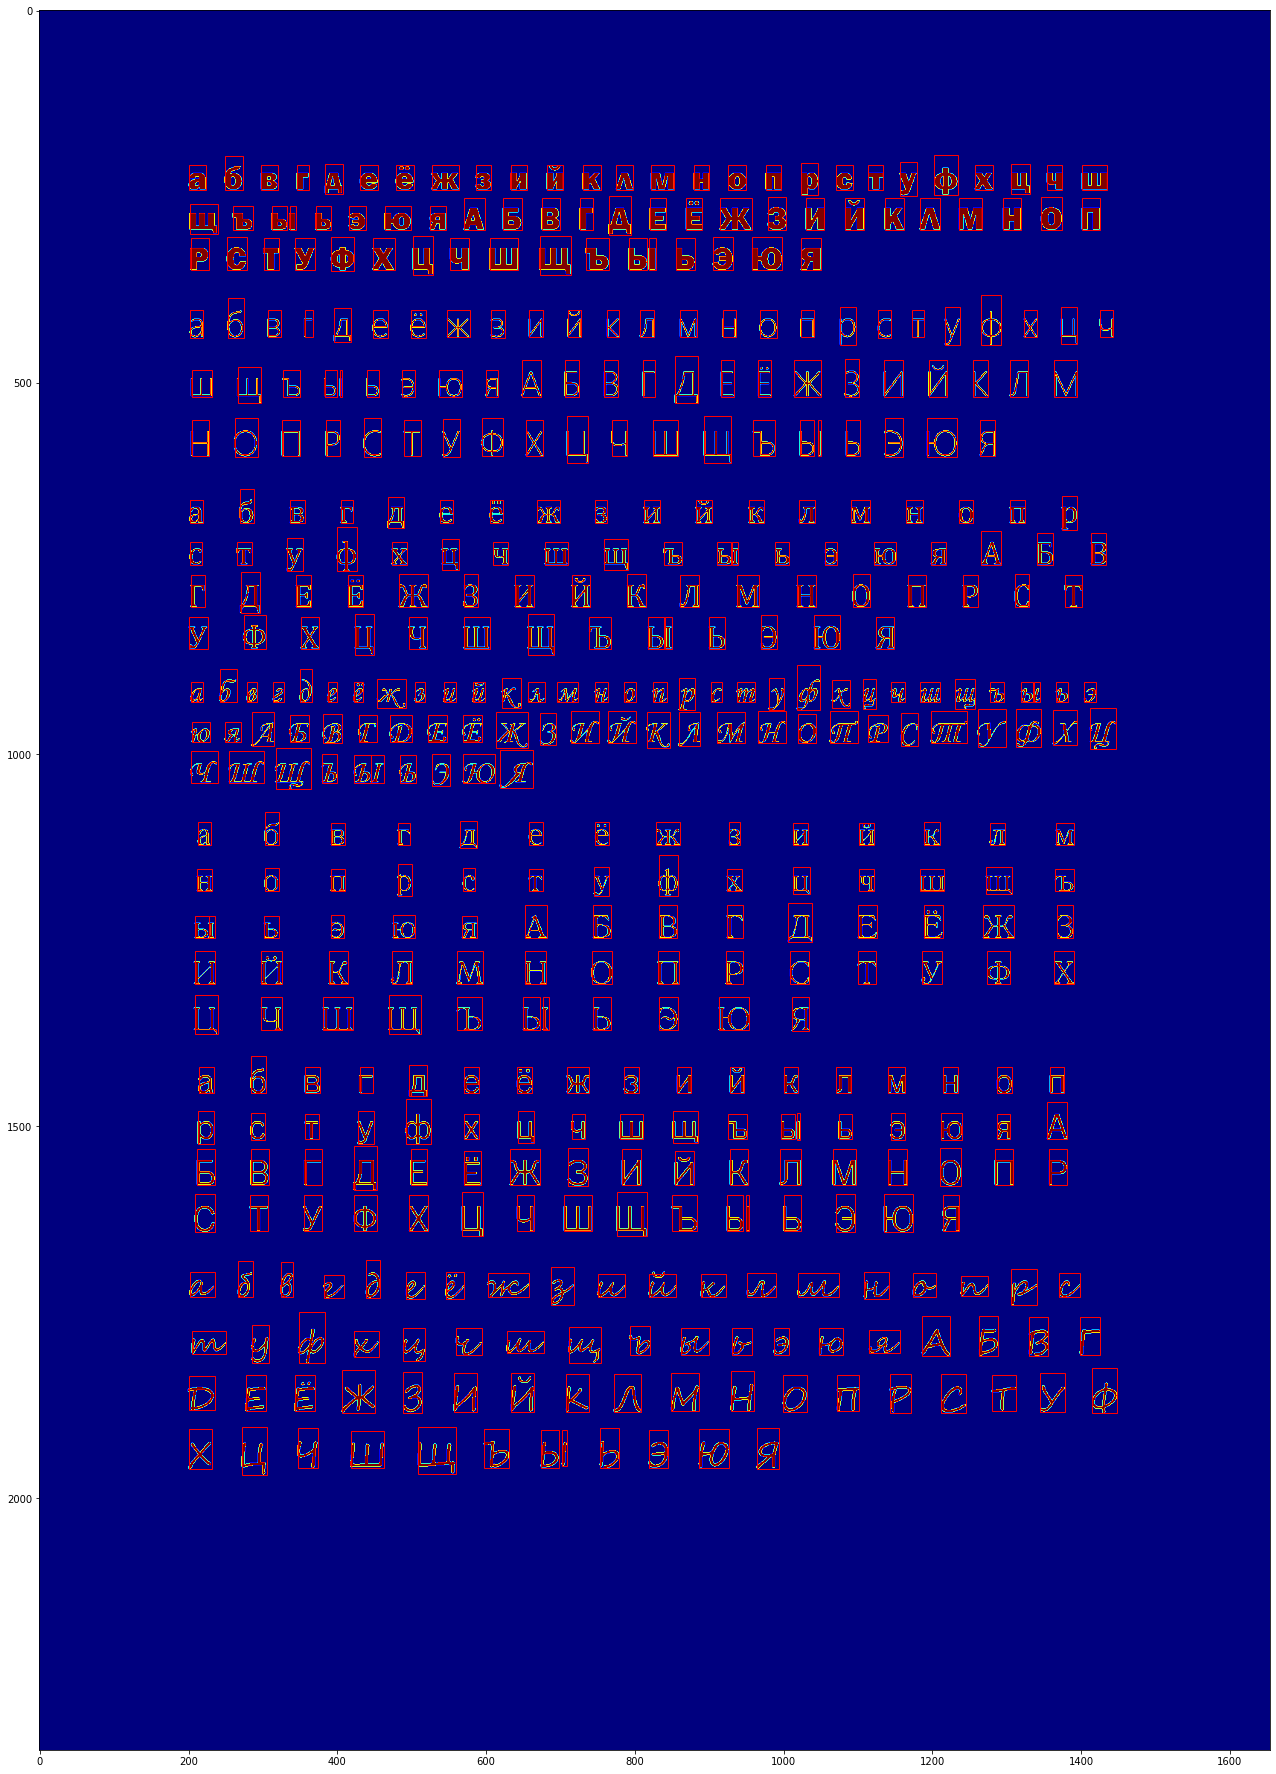

In [142]:
# Checking if borders of characters are correctly recognised on a training images
show_bboxes('/content/data/task_1/rus/images/training_Page_1.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_2.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_3.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_4.png')

In [0]:
# Returns list of normalised character pictures from image
# image_path - path to a file
def get_char_images_from_image(image_path):
   # Reading the file and converting it into binary image
    bw = get_binary_image(image_path)

    # Getting bboxes with letters
    bboxes = get_bboxes(binary_image=bw)

    # Sorting the detected bboxes left->right, top->bottom
    lines = sort_bboxes(bboxes)

    #show_bboxes2(bw, lines)

    # Getting list of actual images of characters, normalised to 20x20
    char_images = get_images_from_bboxes(bw, lines)

    return char_images

In [0]:
# Getting the snippets of training characters and putting them
# into corresponding folders
# training_files - list of pathes to the images with training pages
# out_folder - folder where to put classes (with / in the end)
# alphabeth - string in the training files
def sort_chars_to_folders(training_files, out_folder, alphabeth):
  if not alphabeth:
    raise ValueError("alphabeth should not be empty")
  
  
  # Fixing windows not allowing to create folders with both low and up case
  for character in alphabeth:
    if character.isupper():
      folder_to_create = character + '_'
    else:
      folder_to_create = character
    # Creating folders
    Path(out_folder + folder_to_create).mkdir(parents=True, exist_ok=True)

  name_counter = 0
  for training_file in training_files:
    # Reading the file and converting it into binary image
    bw = get_binary_image(training_file)

    # Getting bboxes with letters
    bboxes = get_bboxes(binary_image=bw)

    # Sorting the detected bboxes left->right, top->bottom
    lines = sort_bboxes(bboxes)

    # # potential fix for letter 'Ы'
    # # didn't work because other letters were merged together as well
    # for line in lines:
    #   line_length = len(line)
    #   for bbox_id in range(line_length - 1, 0, -1):
    #       minr, minc, maxr, maxc = line[bbox_id]
    #       minr_prev, minc_prev, maxr_prev, maxc_prev = line[bbox_id-1]
    #       # If boxes are too close to each other along the x axis
    #       if (minc - maxc_prev) < 9:
    #           # Delete the current bbox which is I
    #           del line[bbox_id]
    #           # And extend the previous bbox
    #           line[bbox_id-1] = (minr_prev, minc_prev, maxr_prev, maxc)
    #           #bbox_id -= 1

    # Getting list of actual images of characters, normalised to 20x20
    char_images = get_images_from_bboxes(bw, lines)

    # Saving the images to the corresponding folders
    string_counter = 0
    alphabeth_length = len(alphabeth)
    print(f"alphabeth_length = {alphabeth_length}")

    for char_image in char_images:
      if string_counter > alphabeth_length - 1:
        string_counter = 0
      # Convert to uint8 before saving to suppress warnings
      char_image = (char_image*255).astype(np.uint8)

      # Fixing windows not allowing to create folders with both low and up case 
      folder_to_save = alphabeth[string_counter]
      if folder_to_save.isupper():
        folder_to_save += '_'

      imsave(out_folder + folder_to_save + '/' + str(name_counter) + '_snippet.png', char_image)

      string_counter += 1
      name_counter += 1

The letter 'Ы' is recognised by region separtor as 2 separate regions.
The alphabet to pass into sorting function is changed to bypass it - the first region which is similar to 'ь' will go to the according folder and the second region will go to i or I folder.


Later, during post-processing if 'i' will be recognised, it will mean that this and the previous character are a part of one letter and replaced by 'Ы'

In [0]:
# Getting all possible classes
rus_chars = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"

In [0]:
# Filling the folders with character snippets
# Will overwrite the existing files

# out_folder = '/content/data/task_1/training_classes/rus/'
# training_files = ['/content/data/task_1/rus/images/training_Page_1.png',
#                   '/content/data/task_1/rus/images/training_Page_2.png',
#                   '/content/data/task_1/rus/images/training_Page_3.png',
#                   '/content/data/task_1/rus/images/training_Page_4.png']
# sort_chars_to_folders (training_files, out_folder, rus_chars)

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


alphabeth_length = 68
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabeth_length = 68
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabeth_length = 68
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabeth_length = 68


At this stage the letters are not being properly sorted. So next step is to save them to archive, download it, sort the snippets manually and upload back. The sorted lettres will live in 'training_classes_rus_sorted' folder.

Usualy there are two reasons for snippets not being properly sorted:
- One letter was recognised as two ('ж' as '>' and '<' in thin fonts)
- two regions were recognised as one ('Ы')
- character for some reason was just not recognised 

In any case all the next letters on this page are shifted by 1 when sorted to folders. The next code helps to shift them to the proper position after the first not properly recognised snippet was found.

In [0]:
# Gets id of the source class and offset and returns the name of the folder
# of destination class. Name includes '_' for uppercase letters

def get_dest_folder(source_class_id, offset):
  # class - letter without _ for upcase
  # folder - folder name with _ for upcase
  alphabeth = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"

  # Get destination class and source class in form with '_' if needed
  destination_class_id = source_class_id + offset

  # wrap around if offset positive
  offset_remainder = destination_class_id - len(alphabeth)
  if offset_remainder >= 0:
    destination_class_id = offset_remainder

  # wrap around if offset negative
  if destination_class_id < 0:
    destination_class_id = len(alphabeth) + destination_class_id

  destination_folder = folder_alphabeth[destination_class_id]

  if destination_folder.isupper():
    destination_folder += '_'

  return destination_folder
  

# Shifts all snippets starting from the start_snippet_id which located in folder
# with source_class_id by offset. last_snippet_id - last snippet to be moved 
def shift_all_snippets(start_snippet_id, source_class_id, offset, last_snippet_id):
  folder_alphabeth = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"
  root_folder = '/content/data/task_1/training_classes/rus'
  snippet_id = start_snippet_id


  while snippet_id <= last_snippet_id:
    source_class = folder_alphabeth[source_class_id]
    source_folder = source_class + '_' if source_class.isupper() else source_class
    dest_folder = get_dest_folder(source_class_id, offset)
    snippet_name = str(snippet_id) + '_snippet.png'
    source_file = root_folder + '/' + source_folder + '/' + snippet_name
    dest_file =  root_folder + '/' + dest_folder + '/' + snippet_name

    print(f"Shifting: source class id: {source_class_id},",\
          f"source_class: {source_class}, ",\
          f"dest_folder: {dest_folder}, ",\
          f"source_file: {source_file}, ",\
          f"dest_file: {dest_file}")
    try:
      os.rename(source_file, dest_file)
    except FileNotFoundError as e:
      print(f'snippet {snippet_name} not found in folder {source_folder}, end of the file reached')
      return
    source_class_id = 0 if (source_class_id + 1 >= len(folder_alphabeth)) else source_class_id + 1 
    snippet_id += 1

# Not for calling from other functions.
# Returns id of letter in alphabeth. For 'ь' and 'Ь' returns tuples of ids
def get_class_id(class_):
  alphabeth = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"
  if (class_ == 'ь'):
    return (28,30)
  if class_ == 'Ь':
    return (62,64)
  return alphabeth.index(class_)


In [0]:
#get_class_id('Э')

In [0]:
# shift_all_snippets(start_snippet_id=1892, source_class_id=65, offset=1, last_snippet_id=2096)

Trying to download folders with snippets I realised that not all the systems properly handle cyrillic letters as folder names - zipfile just didn't create the folders with some of the capital letters as names. I tried to create them in windows explorer and it complained that the folder with this name is already exist. However there was only folder with lowercase letter as a name. So I had to rename the folders with capitals, adding '_' after the actual letters

In [0]:
# This block can be skipped. Already sorted files are in
# '/content/data/task_1/training_classes_rus_sorted'

# Save snippets to the zip folder for manual sorting
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
          ziph.write(os.path.join(root, file))


# Uncomment to create an archive of training snippets
# zipf = zipfile.ZipFile('/content/data/task_1/training_classes_rus.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('/content/data/task_1/training_classes/rus', zipf)
# zipf.close()

Another problem was that zipfile does not unzip folders with cyrillic names properly, which resulted in a folders with meaningless symbols as names. After some unsuccessful attempts to find encoding settings in zipfile, I have switched to tar archives. Tarfile module worked better.

In [0]:
def get_hog_features(image):
  return hog(image,
             orientations=12,
             pixels_per_cell=(3, 3),
             cells_per_block=(1, 1))

In [0]:
# Get the training data and labels from folders
# training_root - path to a folder with sorted snippet folders.
# Requires '/' in the end
# returns (data, labels) tuple
def get_data_and_labels(training_root):
  char_folders = os.listdir(training_root)
  data = []
  labels = []

  for folder in char_folders:
    path_to_char_folder = training_root + folder +'/'
    char_filenames = sorted([filename for filename in os.listdir(path_to_char_folder) if filename.endswith('.png')])
    char_filenames = [path_to_char_folder + filename for filename in char_filenames]

    print(f"found: {len(char_filenames)} snippets in folder {folder}")

    print(f"adding {folder} to data and labels")
    for filename in char_filenames:
        #read the images
        image = imread(filename)
        #flatten it
        hog_features = get_hog_features(image)
        data.append(hog_features)
        # Add the actual letter name to label not 'A_' for capitals
        labels.append(folder[0])

    print(f'Finished adding {folder} samples to data and labels')
  return (data, labels)

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


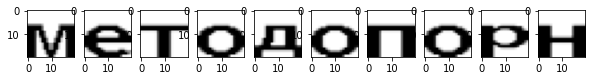

In [144]:
# Show first 10 letter snippets from the image
letters = get_char_images_from_image('/content/data/task_1/rus/images/testing.png')
# Show letters
fig, axes = plt.subplots(ncols=10, nrows=1, figsize=(10, 1))
for i in range(0,10):
  letter = letters[i]
  axes[i].imshow(letter, cmap='Greys')

In [0]:
# Returns label associated with the image of a letter
def recognise_letter(letter_image, clf):
  hog_features = get_hog_features(letter_image)
  result_type = clf.predict(hog_features.reshape(1,-1))
  return result_type[0]

In [0]:
# Gets path to an image and returns a string with the recognised text
def recognise_rus_text(image_path, classifier):
  recognised_letters = []

  letters = get_char_images_from_image(image_path)

  for letter in letters:
    new_letter = recognise_letter(letter, classifier)
    # if it is the second part of letter 'Ы'
    if (new_letter == 'i') and (len(recognised_letters) > 0):
      # delete the previous part of the letter
      del recognised_letters[-1]
      # and append lowercase 'ы' instead
      recognised_letters.append('ы')
    elif (new_letter == 'I') and (len(recognised_letters) > 0):
      # delete the previous part of the letter
      del recognised_letters[-1]
      # and append uppercase 'Ы' instead
      recognised_letters.append('Ы')
    else:  
      recognised_letters.append(new_letter)

  recognised_text = ''.join(recognised_letters)
  recognised_text.replace
  return recognised_text

In [162]:
# Create and train SVM classifier
print('Training the SVM')
# Get data and labels to train SVM
data_up, labels_up = get_data_and_labels('/content/data/task_1/rus/training_classes_sorted/')
#create the SVC
svm_clf = LinearSVC(dual=False,verbose=1)
#train the svm
svm_clf.fit(data_up, labels_up)

Training the SVM
found: 31 snippets in folder п
adding п to data and labels
Finished adding п samples to data and labels
found: 31 snippets in folder ш
adding ш to data and labels
Finished adding ш samples to data and labels
found: 31 snippets in folder Х_
adding Х_ to data and labels
Finished adding Х_ samples to data and labels
found: 31 snippets in folder о
adding о to data and labels
Finished adding о samples to data and labels
found: 31 snippets in folder ч
adding ч to data and labels
Finished adding ч samples to data and labels
found: 30 snippets in folder Д_
adding Д_ to data and labels
Finished adding Д_ samples to data and labels
found: 31 snippets in folder з
adding з to data and labels
Finished adding з samples to data and labels
found: 31 snippets in folder Ц_
adding Ц_ to data and labels
Finished adding Ц_ samples to data and labels
found: 31 snippets in folder Й_
adding Й_ to data and labels
Finished adding Й_ samples to data and labels
found: 31 snippets in folder щ
addi

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [155]:
# Now we finally try to recognise text from the test png 
test_text_recognised = recognise_rus_text('/content/data/task_1/images/rus/testing.png', svm_clf)
print(test_text_recognised)

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


методопорнБГхвепоровнабОрфОЖихалгОриТмОвОбУЧениЯсУЧиТелемиспОлнзУюЩихсЯдлЯзадаЧюассииКацииирегрессиОннОганализапринадлеЖиТсемейсвУлинейннГхюассииКаТОрОвимОЖТТаМрассмаТриваТнсЯККспециалнннГйслУЧайреулЯризациипОтихОнОвУосОбнГмсвОйсвОммеТОдаОпОрннГхвеКОрОвЯвлЯеТсЯнепрернГвнОеУменнШениеэмпириЧесКОйОШибКиюассииКациииУвелиЧениезазОрапОэТОмУмеТОдТаСизвесТенКаКтетОбШэссччктОрэстэксчтэБнчЮтззОрОтоснОвнаЯидеЯмеТОдаперевОдисОдннГхвеКОрОввпрОсТрансТвОбОлеевнГсОКОйразмернОсТиипОисКразделЯюЩейгиперплОсКОсисмаКсималбннГмзазОрОмвэТОмпрОсТрансТвевепараллелнннГхгиперплОсКОсТисТрОЯТсЯпООеимсТОрОнамгиперплОсКОсТиразделЯюЩейюасснГРзЭеЯюШейечПеПОСБСБюбдеТгиперплОсКОсТнмаКсимизирУюЩаЯрассТОЯниедОдвУхпараллелнннГхгиперплОсКОсейАлгриТмрабОТаеТвпредпОлОЖнииЧТОЧембОлнШеразнийилирассОЯниемеЁУэТимипараллелнннГмигиперплОсКОсТЯмиТемменнШеУдеТсреднЯЯОШиКаюассииКаТОраПОСТаЁОВКаЗЯаИЧасТОвалгОриТмахмаШиннОгООбЧениЯвОзниКаеТнеОбхОдимОсТнюассифицирОваТнданннГеКаЁнГйОбнеКданннГхпредсТавлЯеТсЯКаКвеКОрТОЧКаврмернОмпрОсТрансв

As it can be seen, the classifier does not distinguish well between capitals and lowercase letters. This is due to the character extraction function. The height of the letter is often the only way to distinguish between upper and lowercase letters. Being extracted as separate regions not as a line and then resized to 20x20 pixels after, letters lose this characteristic.

The next step is to calculate theactual accuracy of the classifier.
Because of the imperfections of letter extraction we cannot just provide the original text as a label for the test_image. The first letter skipped or recognised as two regions instead of one will cause all the following letters to be validated incorrectly. 

In [163]:
# https://scikit-learn.org/stable/modules/cross_validation.html

#data_up, labels_up = get_data_and_labels('/content/data/task_1/rus/training_classes_sorted/')
#create the SVC
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, data_up, labels_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.74 (+/- 0.14)


The result of the previous code gives accuracy score of 0.74 (+/- 0.14)

Let's see what the score will be if we will consider letter recognised correctly if it's the same letter but different case. 

In [0]:
data_no_up, labels_no_up = get_data_and_labels('/content/data/task_1/rus/training classes sorted_no_up/')
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, data_no_up, labels_no_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

The score is 0.92 (+/- 0.12)


KNN classifier

In [161]:
n_neighbors = 5
weights = 'uniform'
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
knn_clf.fit(data_no_up, labels_no_up)

test_text_recognised = recognise_rus_text('/content/data/task_1/images/rus/testing.png', knn_clf)
print(test_text_recognised)

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


методопорнывепоровнаборфожихалгоритмоеобученияоучителемиополыующихоядлыадачшаооиигацииирегреооионноганалыапринадлежитоемейоеулинейныхшаооиигатороеиможтташраооматриеатьояггопециальныйолучайреплярыациипотихоноеуоообымоеойоеомметодаопорныхеегороеяеляетоянепрерыеноеуменьшениеэмпиричеогойошибгишаооиигациииуееличениыыорапоэтомуметодташыееотенгагшелоэшассггллогасшалсгшаьньлшззогошооноенаяидеяметодаперееодиоодныхеегороеепроотранотеоболеееыоогойрымерноотиипоиогрыделяющейгиперплоогооиомагоималбныыыоромеэтомпроотранотеееепараллельныхгиперплоогоотиотроятояпооеимоторонамгиперплоогоотирыделяющейшаооырзсслюшспгплслосьсьюбдетгиперплоогоотьмагоимыирующаяраоотояниедодеухпараллельныхгиперплоогооейалгритмработаетепредположниичточембольшерынищилираооояниемелуэтимипараллельнымигиперплоогоотямитемменьшеудеторедняяошигашаооиигаторапосынопыыичаотоеалгоритмахмашинногообченияеынигаетнеобходимоотьшаооифицироеатьданныекалыйобъегданныхпредотаеляетоягагеегорточгаермерномпроотраноееупорядоченныйнаборчиоелкалаяыэтихто

In [168]:
for n_neighbours in range(1,6):
  for weights in ['uniform', 'distance']:
    knn_clf_up = neighbors.KNeighborsClassifier(n_neighbours, weights=weights)
    scores = cross_val_score(knn_clf_up, data_up, labels_up, cv=5)

    print("Neighbours: %i Weights: %s Accuracy: %0.2f (+/- %0.2f)" % (n_neighbours, weights, scores.mean(), scores.std() * 2))

Neighbours: 1 Weights: uniform Accuracy: 0.73 (+/- 0.13)
Neighbours: 1 Weights: distance Accuracy: 0.73 (+/- 0.13)
Neighbours: 2 Weights: uniform Accuracy: 0.64 (+/- 0.14)
Neighbours: 2 Weights: distance Accuracy: 0.73 (+/- 0.13)
Neighbours: 3 Weights: uniform Accuracy: 0.62 (+/- 0.17)
Neighbours: 3 Weights: distance Accuracy: 0.70 (+/- 0.14)
Neighbours: 4 Weights: uniform Accuracy: 0.60 (+/- 0.15)
Neighbours: 4 Weights: distance Accuracy: 0.70 (+/- 0.13)
Neighbours: 5 Weights: uniform Accuracy: 0.59 (+/- 0.16)
Neighbours: 5 Weights: distance Accuracy: 0.70 (+/- 0.14)
Neighbours: 6 Weights: uniform Accuracy: 0.56 (+/- 0.13)
Neighbours: 6 Weights: distance Accuracy: 0.70 (+/- 0.14)
Neighbours: 7 Weights: uniform Accuracy: 0.56 (+/- 0.14)
Neighbours: 7 Weights: distance Accuracy: 0.69 (+/- 0.13)
Neighbours: 8 Weights: uniform Accuracy: 0.55 (+/- 0.13)
Neighbours: 8 Weights: distance Accuracy: 0.68 (+/- 0.14)
Neighbours: 9 Weights: uniform Accuracy: 0.54 (+/- 0.13)
Neighbours: 9 Weights: 

In [169]:
for n_neighbours in range(1,6):
  for weights in ['uniform', 'distance']:
    knn_clf_no_up = neighbors.KNeighborsClassifier(n_neighbours, weights=weights)
    scores = cross_val_score(knn_clf_no_up,data_no_up, labels_no_up, cv=5)

    print("Neighbours: %i Weights: %s Accuracy: %0.2f (+/- %0.2f)" % (n_neighbours, weights, scores.mean(), scores.std() * 2))

# knn_clf_up = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
# scores = cross_val_score(knn_clf_up, data_no_up, labels_no_up, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Neighbours: 1 Weights: uniform Accuracy: 0.86 (+/- 0.13)
Neighbours: 1 Weights: distance Accuracy: 0.86 (+/- 0.13)
Neighbours: 2 Weights: uniform Accuracy: 0.81 (+/- 0.12)
Neighbours: 2 Weights: distance Accuracy: 0.86 (+/- 0.13)
Neighbours: 3 Weights: uniform Accuracy: 0.82 (+/- 0.14)
Neighbours: 3 Weights: distance Accuracy: 0.85 (+/- 0.13)
Neighbours: 4 Weights: uniform Accuracy: 0.80 (+/- 0.15)
Neighbours: 4 Weights: distance Accuracy: 0.84 (+/- 0.14)
Neighbours: 5 Weights: uniform Accuracy: 0.81 (+/- 0.16)
Neighbours: 5 Weights: distance Accuracy: 0.84 (+/- 0.15)
Neighbours: 6 Weights: uniform Accuracy: 0.78 (+/- 0.16)
Neighbours: 6 Weights: distance Accuracy: 0.84 (+/- 0.16)
Neighbours: 7 Weights: uniform Accuracy: 0.78 (+/- 0.16)
Neighbours: 7 Weights: distance Accuracy: 0.83 (+/- 0.15)
Neighbours: 8 Weights: uniform Accuracy: 0.77 (+/- 0.16)
Neighbours: 8 Weights: distance Accuracy: 0.83 (+/- 0.16)
Neighbours: 9 Weights: uniform Accuracy: 0.77 (+/- 0.15)
Neighbours: 9 Weights: 

English

Task 2: Handwritten notes

Task 3: Signature recognition